# 🔥 Differentiable Physics Simulation with JAX

Welcome to the second notebook! Here we'll transform our physics simulation into a **differentiable** one using JAX. This is the key insight that enables learning and optimization.

## What You'll Learn

1. **Why Differentiability Matters**: The power of computing gradients
2. **JAX Basics**: Automatic differentiation with `jax.grad`
3. **Differentiable Physics**: Making our simulation JAX-compatible
4. **Gradient-Based Optimization**: Finding optimal force parameters
5. **Visualizing Gradients**: Understanding how parameters affect trajectories

## Prerequisites

- Completed Notebook 01 (Physics Fundamentals)
- Basic understanding of derivatives/gradients

Let's unlock the power of differentiable physics! 🚀


In [1]:
# Setup and imports
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, lax
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from matplotlib.collections import LineCollection
import ipywidgets as widgets
from ipywidgets import interact

# Set up JAX
print(f"JAX version: {jax.__version__}")
print(f"Available devices: {jax.devices()}")

# Plotting defaults
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

print("✅ All imports successful!")


JAX version: 0.8.2
Available devices: [CpuDevice(id=0)]
✅ All imports successful!


## Part 1: Why Differentiability Matters

### The Inverse Problem

In TrajectoryForge, we face an **inverse problem**:
- **Forward problem**: Given force fields → compute trajectory (easy!)
- **Inverse problem**: Given desired trajectory → find force fields (hard!)

### The Gradient Solution

If we can compute:
$$\frac{\partial \mathcal{L}}{\partial \theta}$$

where $\mathcal{L}$ is the loss (trajectory error) and $\theta$ are force field parameters, then we can use **gradient descent** to find optimal parameters:

$$\theta_{new} = \theta_{old} - \alpha \cdot \frac{\partial \mathcal{L}}{\partial \theta}$$


## Part 2: JAX Basics

JAX is a library for high-performance numerical computing with automatic differentiation. Let's learn the basics!


In [2]:
# Basic JAX: automatic differentiation
def f(x):
    return x**2 + 3*x + 1

# Compute derivative automatically!
df_dx = grad(f)

# Test it
x = 2.0
print(f"f(x) = x² + 3x + 1")
print(f"f({x}) = {f(x)}")
print(f"f'(x) = 2x + 3")
print(f"f'({x}) = {df_dx(x)} (computed by JAX)")
print(f"f'({x}) = {2*x + 3} (analytical)")

# Works for any differentiable function!
def g(x):
    return jnp.sin(x) * jnp.exp(-x**2)

dg_dx = grad(g)
x = 1.0
print(f"\ng(x) = sin(x) * exp(-x²)")
print(f"g'({x}) = {dg_dx(x):.6f}")


f(x) = x² + 3x + 1
f(2.0) = 11.0
f'(x) = 2x + 3
f'(2.0) = 7.0 (computed by JAX)
f'(2.0) = 7.0 (analytical)

g(x) = sin(x) * exp(-x²)
g'(1.0) = -0.420354


In [3]:
# Gradients with respect to multiple variables
def h(x, y):
    return x**2 * y + jnp.sin(x * y)

# Gradient w.r.t. first argument (x)
dh_dx = grad(h, argnums=0)
# Gradient w.r.t. second argument (y)
dh_dy = grad(h, argnums=1)
# Gradient w.r.t. both
dh_dxy = grad(h, argnums=(0, 1))

x, y = 1.0, 2.0
print(f"h(x, y) = x²y + sin(xy)")
print(f"∂h/∂x at ({x}, {y}) = {dh_dx(x, y):.4f}")
print(f"∂h/∂y at ({x}, {y}) = {dh_dy(x, y):.4f}")
grad_x, grad_y = dh_dxy(x, y)
print(f"∇h at ({x}, {y}) = ({grad_x:.4f}, {grad_y:.4f})")


h(x, y) = x²y + sin(xy)
∂h/∂x at (1.0, 2.0) = 3.1677
∂h/∂y at (1.0, 2.0) = 0.5839
∇h at (1.0, 2.0) = (3.1677, 0.5839)


## Part 3: Differentiable Physics in JAX

Now let's build our physics simulation in JAX. The key requirements are:
1. Use `jax.numpy` instead of `numpy`
2. Avoid Python control flow that depends on values (use `jax.lax` instead)
3. Use `jax.lax.scan` for loops


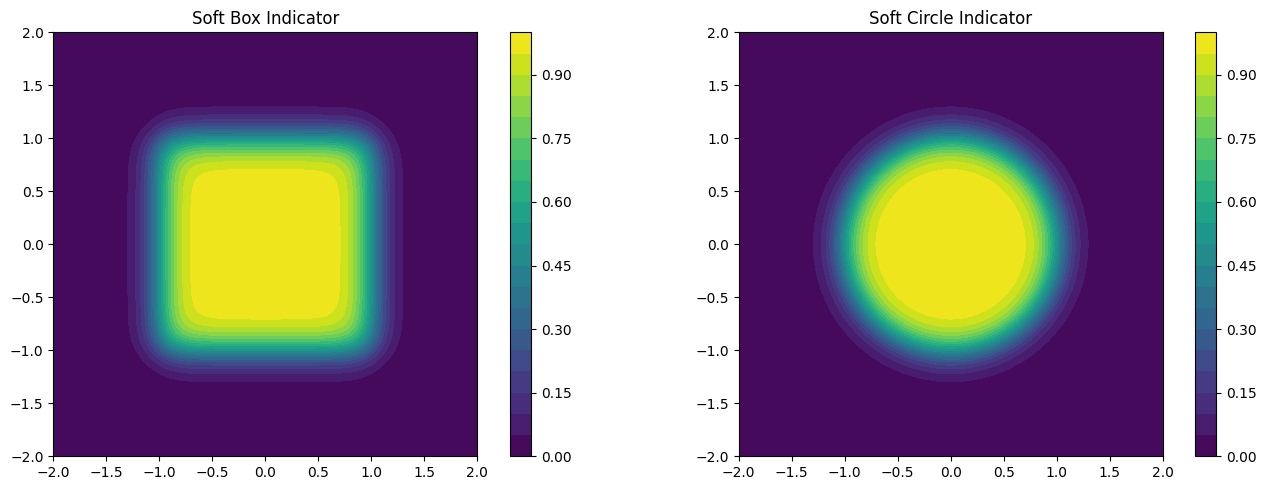

In [4]:
# Soft indicator function (differentiable version of "is inside box")
def soft_indicator_box(position, center, half_size, softness=0.1):
    """Returns ~1 inside box, ~0 outside, with smooth transition."""
    rel_pos = (position - center) / half_size
    scale = 1.0 / softness
    indicators = jax.nn.sigmoid(scale * (1.0 - jnp.abs(rel_pos)))
    return jnp.prod(indicators)

def soft_indicator_circle(position, center, radius, softness=0.1):
    """Returns ~1 inside circle, ~0 outside, with smooth transition."""
    distance = jnp.linalg.norm(position - center)
    return jax.nn.sigmoid((radius - distance) / softness)

# Visualize the soft indicator
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box indicator
ax = axes[0]
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)
for i in range(len(x)):
    for j in range(len(y)):
        Z[j, i] = soft_indicator_box(jnp.array([X[j, i], Y[j, i]]), 
                                      jnp.array([0.0, 0.0]), 
                                      jnp.array([1.0, 1.0]), 
                                      softness=0.1)
im = ax.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar(im, ax=ax)
ax.set_title('Soft Box Indicator')
ax.set_aspect('equal')

# Circle indicator
ax = axes[1]
Z = np.zeros_like(X)
for i in range(len(x)):
    for j in range(len(y)):
        Z[j, i] = soft_indicator_circle(jnp.array([X[j, i], Y[j, i]]), 
                                         jnp.array([0.0, 0.0]), 
                                         1.0, 
                                         softness=0.1)
im = ax.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar(im, ax=ax)
ax.set_title('Soft Circle Indicator')
ax.set_aspect('equal')

plt.tight_layout()
plt.show()


In [5]:
# Differentiable Wind Field
def wind_force(position, velocity, center, half_size, direction, strength, softness=0.1):
    """Compute wind force - fully differentiable."""
    indicator = soft_indicator_box(position, center, half_size, softness)
    return strength * direction * indicator

# Differentiable simulation step
def physics_step(state, params, dt=0.01, mass=1.0):
    """
    One step of semi-implicit Euler integration.
    state: (position, velocity) tuple
    params: dictionary with field parameters
    """
    position, velocity = state
    
    # Compute force from wind field
    force = wind_force(
        position, velocity,
        params['wind_center'],
        params['wind_half_size'],
        params['wind_direction'],
        params['wind_strength']
    )
    
    # Semi-implicit Euler
    acceleration = force / mass
    new_velocity = velocity + acceleration * dt
    new_position = position + new_velocity * dt
    
    return (new_position, new_velocity)

# Differentiable simulation using lax.scan
def simulate(initial_pos, initial_vel, params, dt=0.01, num_steps=200):
    """
    Run full simulation - differentiable w.r.t. params!
    """
    def scan_fn(state, _):
        new_state = physics_step(state, params, dt)
        return new_state, state[0]  # Return new state, output position
    
    initial_state = (initial_pos, initial_vel)
    _, positions = lax.scan(scan_fn, initial_state, None, length=num_steps)
    
    return positions

# Test the simulation
params = {
    'wind_center': jnp.array([1.5, 0.5]),
    'wind_half_size': jnp.array([1.0, 1.5]),
    'wind_direction': jnp.array([0.0, 1.0]),
    'wind_strength': 8.0,
}

init_pos = jnp.array([0.0, 0.0])
init_vel = jnp.array([1.5, 0.0])

positions = simulate(init_pos, init_vel, params, dt=0.01, num_steps=300)
print(f"Simulated {len(positions)} steps")
print(f"Final position: {positions[-1]}")


Simulated 300 steps
Final position: [ 4.485008 12.912559]


## Part 4: Computing Gradients Through the Simulation

Now for the magic! We can compute gradients of the trajectory with respect to force field parameters.


In [6]:
# Define a loss function: distance from target endpoint
def endpoint_loss(wind_strength, init_pos, init_vel, target_endpoint):
    """Loss = squared distance from final position to target."""
    params = {
        'wind_center': jnp.array([1.5, 0.5]),
        'wind_half_size': jnp.array([1.0, 1.5]),
        'wind_direction': jnp.array([0.0, 1.0]),
        'wind_strength': wind_strength,
    }
    positions = simulate(init_pos, init_vel, params, dt=0.01, num_steps=300)
    final_pos = positions[-1]
    return jnp.sum((final_pos - target_endpoint) ** 2)

# Compute gradient of loss w.r.t. wind strength!
grad_loss = grad(endpoint_loss)

init_pos = jnp.array([0.0, 0.0])
init_vel = jnp.array([1.5, 0.0])
target = jnp.array([4.0, 2.0])

# Test gradient at different wind strengths
print("Wind Strength | Loss    | Gradient")
print("-" * 40)
for strength in [0.0, 5.0, 10.0, 15.0, 20.0]:
    loss = endpoint_loss(strength, init_pos, init_vel, target)
    gradient = grad_loss(strength, init_pos, init_vel, target)
    print(f"{strength:12.1f} | {loss:7.3f} | {gradient:+.4f}")


Wind Strength | Loss    | Gradient
----------------------------------------
         0.0 |   4.235 | -10.5948
         5.0 |  61.566 | +18.3487
        10.0 | 159.710 | +20.4248
        15.0 | 263.351 | +20.9006
        20.0 | 367.887 | +20.8599


## Part 5: Gradient Descent Optimization

Now let's use gradient descent to find the optimal wind strength to hit a target!


Iter   0: strength=0.761, loss=0.2579
Iter  10: strength=0.468, loss=68.3978
Iter  20: strength=-1.081, loss=30.8192
Iter  30: strength=-1.863, loss=13.2762
Iter  40: strength=0.542, loss=70.0833
Iter  50: strength=-0.562, loss=44.0657

Optimal wind strength: 2.911


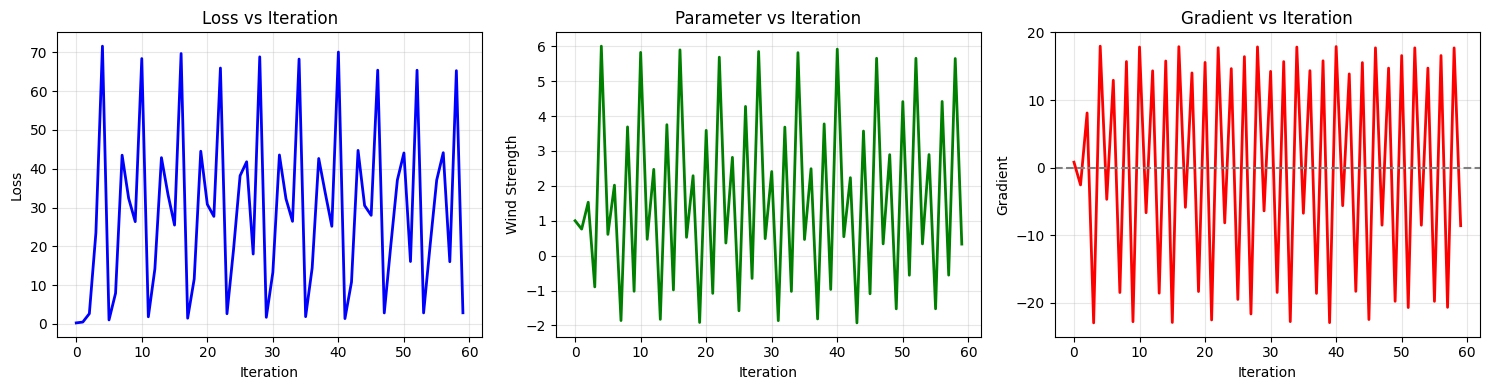

In [7]:
def optimize_wind_strength(init_strength, target, learning_rate=0.5, num_iters=50):
    """Find optimal wind strength using gradient descent."""
    strength = init_strength
    history = {'strength': [], 'loss': [], 'gradient': []}
    
    for i in range(num_iters):
        loss = endpoint_loss(strength, init_pos, init_vel, target)
        gradient = grad_loss(strength, init_pos, init_vel, target)
        
        history['strength'].append(float(strength))
        history['loss'].append(float(loss))
        history['gradient'].append(float(gradient))
        
        # Gradient descent step
        strength = strength - learning_rate * gradient
        
        if i % 10 == 0:
            print(f"Iter {i:3d}: strength={strength:.3f}, loss={loss:.4f}")
    
    return strength, history

# Run optimization
target = jnp.array([4.0, 2.5])
optimal_strength, history = optimize_wind_strength(1.0, target, learning_rate=0.3, num_iters=60)
print(f"\nOptimal wind strength: {optimal_strength:.3f}")

# Visualize optimization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['loss'], 'b-', linewidth=2)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss vs Iteration')
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['strength'], 'g-', linewidth=2)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Wind Strength')
axes[1].set_title('Parameter vs Iteration')
axes[1].grid(True, alpha=0.3)

axes[2].plot(history['gradient'], 'r-', linewidth=2)
axes[2].axhline(y=0, color='gray', linestyle='--')
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Gradient')
axes[2].set_title('Gradient vs Iteration')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


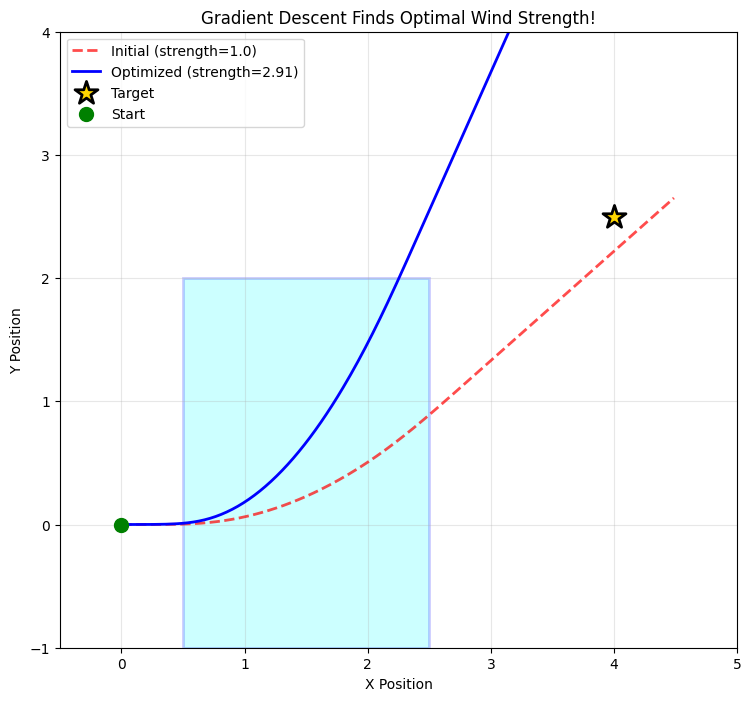

Distance to target: 4.5339


In [8]:
# Visualize the optimized trajectory
fig, ax = plt.subplots(figsize=(12, 8))

# Initial trajectory (before optimization)
params_init = {
    'wind_center': jnp.array([1.5, 0.5]),
    'wind_half_size': jnp.array([1.0, 1.5]),
    'wind_direction': jnp.array([0.0, 1.0]),
    'wind_strength': 1.0,
}
positions_init = simulate(init_pos, init_vel, params_init, dt=0.01, num_steps=300)
ax.plot(positions_init[:, 0], positions_init[:, 1], 'r--', linewidth=2, 
        label=f'Initial (strength=1.0)', alpha=0.7)

# Optimized trajectory
params_opt = {
    'wind_center': jnp.array([1.5, 0.5]),
    'wind_half_size': jnp.array([1.0, 1.5]),
    'wind_direction': jnp.array([0.0, 1.0]),
    'wind_strength': optimal_strength,
}
positions_opt = simulate(init_pos, init_vel, params_opt, dt=0.01, num_steps=300)
ax.plot(positions_opt[:, 0], positions_opt[:, 1], 'b-', linewidth=2, 
        label=f'Optimized (strength={optimal_strength:.2f})')

# Draw target
ax.scatter([target[0]], [target[1]], c='gold', s=300, marker='*', 
           edgecolors='black', linewidths=2, zorder=5, label='Target')

# Draw wind region
rect = Rectangle([0.5, -1.0], 2.0, 3.0, fill=True, facecolor='cyan', 
                 alpha=0.2, edgecolor='blue', linewidth=2)
ax.add_patch(rect)

# Draw start/end
ax.scatter([0], [0], c='green', s=100, zorder=5, label='Start')
ax.scatter([positions_opt[-1, 0]], [positions_opt[-1, 1]], c='blue', s=100, zorder=5)

ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Gradient Descent Finds Optimal Wind Strength!')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(-0.5, 5)
ax.set_ylim(-1, 4)
ax.set_aspect('equal')
plt.show()

print(f"Distance to target: {jnp.linalg.norm(positions_opt[-1] - target):.4f}")


## Part 6: Using the TrajectoryForge Physics Module

Now let's use the actual physics module we built for the project!


In [ ]:
# Add parent directory to path to import our physics module
import sys
sys.path.insert(0, '..')

from physics.state import PhysicsState, SimulationConfig
from physics.fields import WindField, VortexField, PointForce
from physics.simulator import simulate_trajectory, simulate_positions_only, trajectory_loss_same_length
from physics.utils import generate_arc_trajectory, generate_sine_wave_trajectory

print("✅ Successfully imported TrajectoryForge physics module!")


## Summary

In this notebook, we learned:

1. **Why Differentiability Matters**: Enables gradient-based optimization
2. **JAX Basics**: `grad`, `jit`, and `lax.scan` for automatic differentiation
3. **Soft Functions**: Replace hard boundaries with smooth approximations
4. **Gradient Computation**: Compute ∂Loss/∂params through entire simulation
5. **Optimization**: Use gradient descent to find optimal parameters

## Key Takeaways

- **Differentiable physics** lets us backpropagate through simulations
- **Soft boundaries** ensure smooth gradients everywhere
- **Gradient descent** can find force configurations that produce desired trajectories

## Next Steps

In the next notebook, we'll tackle **trajectory optimization** - finding force field configurations that match entire curved paths, not just endpoints!

See you in **03_trajectory_optimization.ipynb**! 🚀
